# Project Statement

Assalamu alaikum, welcome to my notebook.

As part of mlc.course's `assignment 3`, we were told to analyze some `bagging and boosting techniques` on customer churn dataset. This notebook goes through dataset description, data vizualization and modelling stages.

What makes this interesting as composed to other assignmets is that we have to choose right evaluation metric. `Accuracy` would be unfair just beacuse of this type of dataset tended to unbalanced dataset (in this case 80/20ish). `Recall` would be foremost as we need to be aware of customers who are likely to churn, but we can fool it easily by classifying churn even customers have little chance. So, I choose `F1 score` to make a balance between recision and recall.

In [1]:
!pip install -qq bayesian-optimization
!pip install -U colorama

from bayes_opt import BayesianOptimization

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 7)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


As I do not have exact definition for dataset, here my gentle guesses on what are you seeing as features:

- **RowNumber** - index of customers
- **CustomerId** - unique customer identification of customers
- **Surname** - surname of customer
- **CreditScore** - estimated credit score of each customer ranging from 350 to 850
- **Geography** - location of customer one of 3 countries France, Spain or Germany
- **Gender** - male or female
- **Age** - age
- **Tenure** - I don't know
- **Balance** - customer's balance on credit card
- **NumOfProducts** - number of products customer purchased from company
- **HasCrCard** - whether customer connected Credit Card to the system
- **IsActiveMember** - whether customer frequently uses company's products
- **EstimatedSalary** - estimated salary of customer
- **Exited** - whether customer churned or not

As you might guess, we do not need `RowNumber`, `CustomerId`, `Surname` features to make a classification.

In [4]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [5]:
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

# Data Vizualization

I prefer to firstly looking overall visualization of dataset to get intial intuition so go further if needed. Correlation Matrix is good starting point.

In [6]:
dep_var='Exited'
features=df.drop(dep_var, axis=1).columns.tolist()

cat_names=['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
cont_names=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

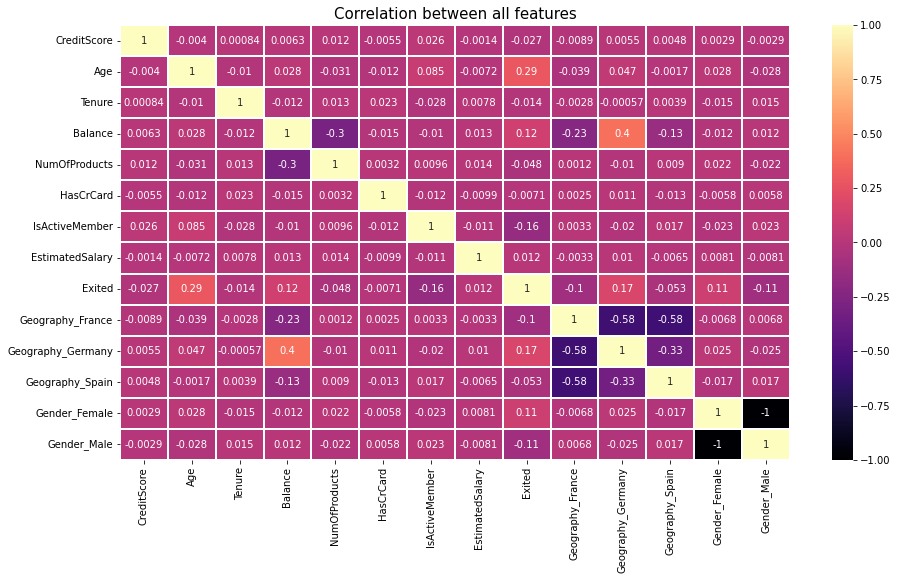

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(pd.get_dummies(df).corr(), annot=True, cmap='magma', linewidths=0.1, ax=ax)
plt.title('Correlation between all features', 
          fontsize='15', fontfamily='sans-serif');

For knowing each features, I ploted **Box Plot** for continuos features and **Count Plot** for categorical ones.

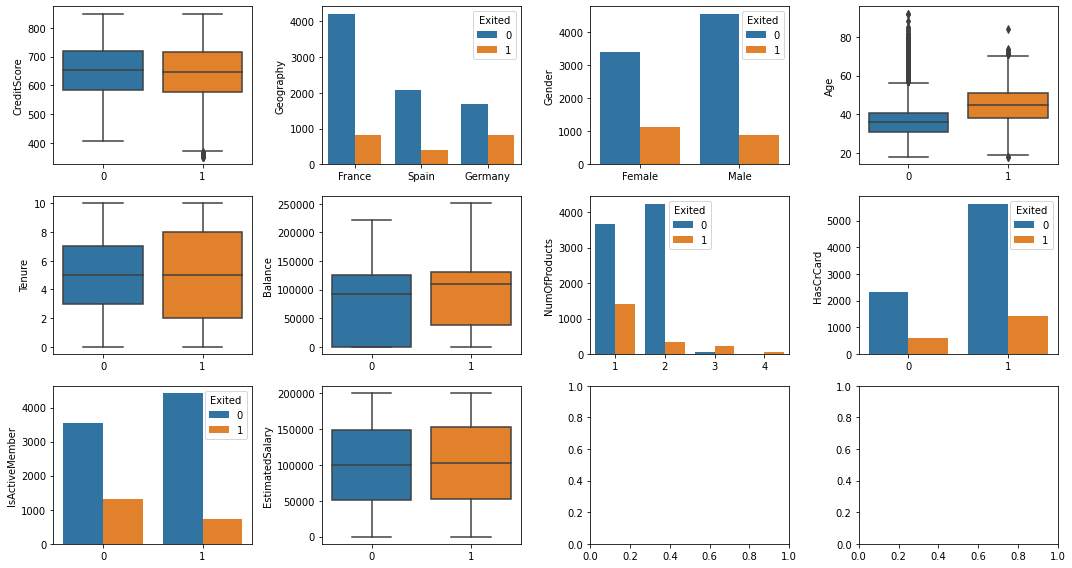

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))

for idx, feat in enumerate(features):
    ax = axes[int(idx / 4), idx % 4]
    if feat in cat_names:
        sns.countplot(x=feat, hue="Exited", data=df, ax=ax);
        ax.set_xlabel("")
        ax.set_ylabel(feat)
    else:
        sns.boxplot(x="Exited", y=feat, data=df, ax=ax)
        ax.set_xlabel("")
        ax.set_ylabel(feat)
fig.tight_layout();

Below is plot to show that I know how to plot. If you don't know, now you know.

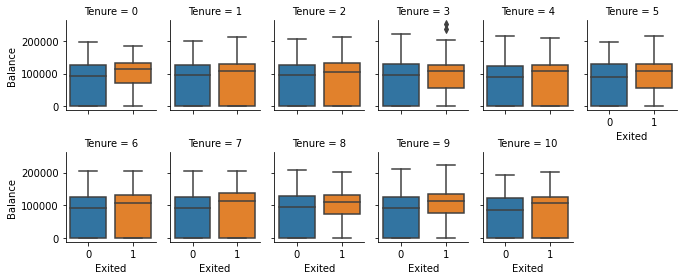

In [9]:
sns.catplot(
    x="Exited",
    y="Balance",
    col="Tenure",
    data=df,
    kind="box",
    col_wrap=6,
    height=2,
    aspect=0.8,
);

## PCA and KMeans

Pricipal Component Analysis and K-Means clustering to see how target labels are located.

In [10]:
from sklearn.preprocessing import StandardScaler

X_scaled=pd.get_dummies(df[features])
y=df[dep_var]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_scaled)

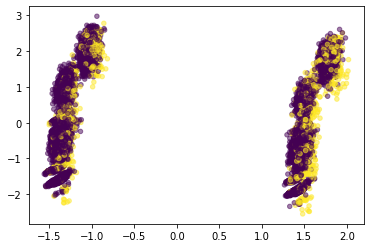

In [11]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2).fit(X_scaled)
X_pca=pca.transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, alpha=0.5, cmap="viridis");

As you see, it is pretty hard to classify into two categories

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=1000, random_state=25)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

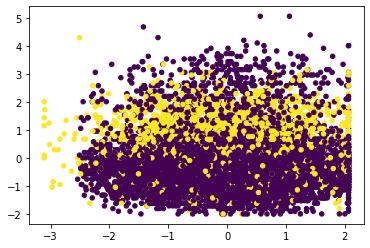

In [13]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=20, cmap="viridis");

At the time of writing this, I can't come up with additional feature because of shortages on dataset. (Okay I am lazy, just a little bit)

# Modelling

In this part, I initially encoded categorical features using One-Hot Encoding then I split dataset between 90% train and 10% test sets on a stratified fashion. The reason for only 10% is that we are short on dataset.

Then, I tried `DecisionTreeClassifier`, `RandomForestClassifier`, `AdaBoostClassifier` and `GradientBoostingClassifer` baseline and hyperparameter tuned version with **BayesianOptimization** so that we will get more quality parameters than RandomSearchCV and more computationally effective than GridSearchCV.

In [14]:
df=pd.get_dummies(df)

features=df.drop(['Exited'], axis=1).columns.tolist()

In [15]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[dep_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True) 

In [16]:
y.mean(), y_train.mean(), y_test.mean()

(0.2037, 0.20366666666666666, 0.204)

## Decision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

tree = DecisionTreeClassifier(random_state=25)
tree.fit(X_train, y_train)

tree_score = f1_score(y_test, tree.predict(X_test))
tree_score

0.5187032418952617

In [18]:
def tree_BO(max_depth, min_samples_leaf, max_features, class_weight):
    max_depth = round(max_depth)
    min_samples_leaf = round(min_samples_leaf)
    class_weight = round(class_weight)
    
    cw = [None, 'balanced']
    
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=cw[class_weight],
        random_state=25
    )
    tree.fit(X_train, y_train)
    
    return f1_score(y_test, tree.predict(X_test))

tree_pbounds = {
    'max_depth': (2, 10),
    'min_samples_leaf': (25, 100),
    'max_features': (1e-6, 1),
    'class_weight': (0, 1)
}

In [19]:
tree_optimizer = BayesianOptimization(
    f=tree_BO,
    pbounds=tree_pbounds,
    random_state=1,
    verbose=1
)

tree_optimizer.maximize(n_iter=20)

|   iter    |  target   | class_... | max_depth | max_fe... | min_sa... |
-------------------------------------------------------------------------
| 3         | 0.5342    | 0.3968    | 6.311     | 0.4192    | 76.39     |
| 8         | 0.5435    | 0.6234    | 3.786     | 0.9591    | 85.35     |
| 11        | 0.5505    | 0.9953    | 4.601     | 0.8169    | 28.35     |
| 12        | 0.5543    | 0.9812    | 4.163     | 0.8088    | 58.49     |


In [20]:
tree_optimizer.max['target']

0.5543478260869564

In [21]:
best_tree = DecisionTreeClassifier(
    max_depth=round(tree_optimizer.max['params']['max_depth']),
    min_samples_leaf=round(tree_optimizer.max['params']['min_samples_leaf']),
    max_features=tree_optimizer.max['params']['max_features'],
    class_weight='balanced',
    random_state=25
    )
best_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       max_features=0.8087852092847501, min_samples_leaf=58,
                       random_state=25)

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=25)
rf.fit(X_train, y_train)

rf_score = f1_score(y_test, rf.predict(X_test))
rf_score

0.5911949685534591

In [23]:
def rf_BO(n_estimators, min_samples_leaf, max_depth, max_features, class_weight, max_samples):
    n_estimators = round(n_estimators)
    min_samples_leaf = round(min_samples_leaf)
    max_depth = round(max_depth)
    class_weight = round(class_weight)
    
    cw = [None, 'balanced']
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=cw[class_weight],
        max_samples=max_samples,
        random_state=25,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    return f1_score(y_test, rf.predict(X_test))

rf_pbounds = {
    'n_estimators': (80, 1000),
    'max_depth': (2, 10),
    'min_samples_leaf': (25, 100),
    'max_features': (1e-6, 1),
    'class_weight': (0, 1),
    'max_samples': (1e-6, 1)
}

In [24]:
rf_optimizer = BayesianOptimization(
    f=rf_BO,
    pbounds=rf_pbounds,
    random_state=1,
    verbose=1
)

rf_optimizer.maximize(n_iter=20)

|   iter    |  target   | class_... | max_depth | max_fe... | max_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 2         | 0.4588    | 0.1863    | 4.764     | 0.3968    | 0.5388    | 56.44     | 710.4     |
| 4         | 0.5084    | 0.1404    | 3.585     | 0.8007    | 0.9683    | 48.51     | 716.9     |
| 5         | 0.5164    | 0.8764    | 9.157     | 0.08505   | 0.03906   | 37.74     | 887.9     |
| 8         | 0.5737    | 0.8876    | 9.66      | 0.9602    | 0.9822    | 39.76     | 890.0     |
| 9         | 0.588     | 0.8935    | 7.165     | 0.4591    | 0.5679    | 40.54     | 888.5     |
| 12        | 0.5911    | 0.6417    | 8.861     | 0.53      | 0.8144    | 40.19     | 885.5     |
| 16        | 0.5919    | 0.9082    | 4.744     | 0.559     | 0.8616    | 40.21     | 880.9     |


In [25]:
rf_optimizer.max['target']

0.5918762088974855

In [26]:
best_rf = RandomForestClassifier(
    n_estimators = round(rf_optimizer.max['params']['n_estimators']),
    max_depth=round(rf_optimizer.max['params']['max_depth']),
    min_samples_leaf=round(rf_optimizer.max['params']['min_samples_leaf']),
    max_features=rf_optimizer.max['params']['max_features'],
    class_weight='balanced',
    random_state=25
    )

best_rf

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features=0.5589588623712152, min_samples_leaf=40,
                       n_estimators=881, random_state=25)

## Ada Boost

As AdaBoostClassifier and GradientBoostingClassifier can take initial model as an input, I trained 3 models in total: one with deafult initial model and one with best decision tree and one with random forest.

In [27]:
from sklearn.ensemble import AdaBoostClassifier

ab=AdaBoostClassifier(random_state=25)
ab.fit(X_train, y_train)

f1_score(y_test, ab.predict(X_test))

0.5617283950617284

In [28]:
def ab_BO(n_estimators, learning_rate):
    n_estimators = round(n_estimators)
        
    ab = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )
    ab.fit(X_train, y_train)

    return f1_score(y_test, ab.predict(X_test))

ab_pbounds = {
    'n_estimators': (80, 300),
    'learning_rate': (1e-6, 1)
}

In [29]:
ab_optimizer = BayesianOptimization(
    f=ab_BO,
    pbounds=ab_pbounds,
    random_state=1,
    verbose=1
)

ab_optimizer.maximize(n_iter=20)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 18        | 0.5517    | 0.195     | 281.4     |


In [30]:
ab_optimizer.max['target']

0.5517241379310345

In [31]:
best_ab = AdaBoostClassifier(
    n_estimators=round(ab_optimizer.max['params']['n_estimators']),
    learning_rate=ab_optimizer.max['params']['learning_rate']
    )

best_ab

AdaBoostClassifier(learning_rate=0.19499465628721888, n_estimators=281)

In [32]:
def ab_BO(n_estimators, learning_rate):
    n_estimators = round(n_estimators)
        
    ab = AdaBoostClassifier(
        base_estimator=best_tree,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )
    ab.fit(X_train, y_train)

    return f1_score(y_test, ab.predict(X_test))

ab_pbounds = {
    'n_estimators': (80, 300),
    'learning_rate': (1e-6, 1)
}

In [33]:
ab_optimizer_tree = BayesianOptimization(
    f=ab_BO,
    pbounds=ab_pbounds,
    random_state=1,
    verbose=1
)

ab_optimizer_tree.maximize(n_iter=20)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 3         | 0.5945    | 0.1468    | 100.3     |
| 6         | 0.6118    | 0.04625   | 101.3     |


In [34]:
ab_optimizer_tree.max['target']

0.6117647058823529

In [35]:
best_ab_tree = AdaBoostClassifier(
    base_estimator=best_tree,
    n_estimators=round(ab_optimizer_tree.max['params']['n_estimators']),
    learning_rate=ab_optimizer_tree.max['params']['learning_rate']
    )

best_ab_tree

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=4,
                                                         max_features=0.8087852092847501,
                                                         min_samples_leaf=58,
                                                         random_state=25),
                   learning_rate=0.04624937694112917, n_estimators=101)

In [36]:
base_rf = RandomForestClassifier(class_weight='balanced', 
                                     random_state=25)

def ab_BO(n_estimators, learning_rate):
    n_estimators = round(n_estimators)
    
    ab = AdaBoostClassifier(
        base_estimator=base_rf,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )
    ab.fit(X_train, y_train)

    return f1_score(y_test, ab.predict(X_test))

ab_pbounds = {
    'n_estimators': (80, 300),
    'learning_rate': (1e-6, 1)
}

In [37]:
ab_optimizer_rf = BayesianOptimization(
    f=ab_BO,
    pbounds=ab_pbounds,
    random_state=1,
    verbose=1
)

ab_optimizer_rf.maximize(n_iter=20)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 5         | 0.5751    | 0.3968    | 198.5     |


In [38]:
ab_optimizer_rf.max['target']

0.5750798722044728

In [39]:
best_ab_rf = AdaBoostClassifier(
    base_estimator=base_rf,
    n_estimators=round(ab_optimizer_rf.max['params']['n_estimators']),
    learning_rate=ab_optimizer_rf.max['params']['learning_rate']
    )

best_ab_rf

AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                         random_state=25),
                   learning_rate=0.39676807746319565, n_estimators=199)

## Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb=GradientBoostingClassifier(random_state=25)
gb.fit(X_train, y_train)

f1_score(y_test, gb.predict(X_test))

0.5562499999999999

In [41]:
def gb_BO(learning_rate, n_estimators, min_samples_leaf, max_depth, max_features):
    n_estimators = round(n_estimators)
    min_samples_leaf = round(min_samples_leaf)
    max_depth = round(max_depth)
    
    gb = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=25
    )
    gb.fit(X_train, y_train)
    
    return f1_score(y_test, gb.predict(X_test))

gb_pbounds = {
    'learning_rate': (1e-6, 1),
    'n_estimators': (80, 300),
    'max_depth': (2, 10),
    'min_samples_leaf': (25, 100),
    'max_features': (1e-6, 1),
}

In [42]:
gb_optimizer = BayesianOptimization(
    f=gb_BO,
    pbounds=gb_pbounds,
    random_state=1,
    verbose=1
)

gb_optimizer.maximize(n_iter=20)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 2         | 0.5678    | 0.09234   | 3.49      | 0.3456    | 54.76     | 198.5     |
| 3         | 0.5812    | 0.4192    | 7.482     | 0.2045    | 90.86     | 86.03     |
| 7         | 0.5965    | 0.2999    | 5.668     | 0.5861    | 80.73     | 184.3     |


In [43]:
gb_optimizer.max['target']

0.5964912280701754

In [44]:
best_gb = GradientBoostingClassifier(
    learning_rate=gb_optimizer.max['params']['learning_rate'],
    n_estimators=round(gb_optimizer.max['params']['n_estimators']),
    max_depth=round(gb_optimizer.max['params']['max_depth']),
    min_samples_leaf=round(gb_optimizer.max['params']['min_samples_leaf']),
    max_features=gb_optimizer.max['params']['max_features'],
    random_state=25
    )
best_gb

GradientBoostingClassifier(learning_rate=0.29989933296341553, max_depth=6,
                           max_features=0.586138168548575, min_samples_leaf=81,
                           n_estimators=184, random_state=25)

In [45]:
def gb_BO(learning_rate, n_estimators, min_samples_leaf, max_depth, max_features):
    n_estimators = round(n_estimators)
    min_samples_leaf = round(min_samples_leaf)
    max_depth = round(max_depth)
    
    gb = GradientBoostingClassifier(
        init=best_tree,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=25
    )
    gb.fit(X_train, y_train)
    
    return f1_score(y_test, gb.predict(X_test))

gb_pbounds = {
    'learning_rate': (1e-6, 1),
    'n_estimators': (80, 300),
    'max_depth': (2, 10),
    'min_samples_leaf': (25, 100),
    'max_features': (1e-6, 1),
}

In [46]:
gb_optimizer_tree = BayesianOptimization(
    f=gb_BO,
    pbounds=gb_pbounds,
    random_state=1,
    verbose=1
)

gb_optimizer_tree.maximize(n_iter=20)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 23        | 0.593     | 0.1833    | 7.411     | 0.06345   | 48.26     | 112.7     |


In [47]:
gb_optimizer_tree.max['target']

0.5930232558139534

In [48]:
best_gb_tree = GradientBoostingClassifier(
    init=best_tree,
    learning_rate=gb_optimizer_tree.max['params']['learning_rate'],
    n_estimators=round(gb_optimizer_tree.max['params']['n_estimators']),
    max_depth=round(gb_optimizer_tree.max['params']['max_depth']),
    min_samples_leaf=round(gb_optimizer_tree.max['params']['min_samples_leaf']),
    max_features=gb_optimizer_tree.max['params']['max_features'],
    random_state=25
    )
best_gb_tree

GradientBoostingClassifier(init=DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=4,
                                                       max_features=0.8087852092847501,
                                                       min_samples_leaf=58,
                                                       random_state=25),
                           learning_rate=0.18333455893273487, max_depth=7,
                           max_features=0.06345389880778655,
                           min_samples_leaf=48, n_estimators=113,
                           random_state=25)

In [49]:
def gb_BO(learning_rate, n_estimators, min_samples_leaf, max_depth, max_features):
    n_estimators = round(n_estimators)
    min_samples_leaf = round(min_samples_leaf)
    max_depth = round(max_depth)
    
    gb = GradientBoostingClassifier(
        init=base_rf,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=25
    )
    gb.fit(X_train, y_train)
    
    return f1_score(y_test, gb.predict(X_test))

gb_pbounds = {
    'learning_rate': (1e-6, 1),
    'n_estimators': (80, 300),
    'max_depth': (2, 10),
    'min_samples_leaf': (25, 100),
    'max_features': (1e-6, 1),
}

In [50]:
gb_optimizer_rf = BayesianOptimization(
    f=gb_BO,
    pbounds=gb_pbounds,
    random_state=1,
    verbose=1
)

gb_optimizer_rf.maximize(n_iter=20)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 2         | 0.5944    | 0.09234   | 3.49      | 0.3456    | 54.76     | 198.5     |
| 7         | 0.5964    | 0.2999    | 5.668     | 0.5861    | 80.73     | 184.3     |


In [51]:
gb_optimizer_rf.max['target']

0.5963855421686747

In [52]:
best_gb_rf = GradientBoostingClassifier(
    init=base_rf,
    learning_rate=gb_optimizer_tree.max['params']['learning_rate'],
    n_estimators=round(gb_optimizer_tree.max['params']['n_estimators']),
    max_depth=round(gb_optimizer_tree.max['params']['max_depth']),
    min_samples_leaf=round(gb_optimizer_tree.max['params']['min_samples_leaf']),
    max_features=gb_optimizer_tree.max['params']['max_features'],
    random_state=25
    )

best_gb_rf

GradientBoostingClassifier(init=RandomForestClassifier(class_weight='balanced',
                                                       random_state=25),
                           learning_rate=0.18333455893273487, max_depth=7,
                           max_features=0.06345389880778655,
                           min_samples_leaf=48, n_estimators=113,
                           random_state=25)

# Model Summary

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def model_summary(model):
    model = model.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, model.predict(X_test))
    pre = precision_score(y_test, model.predict(X_test))
    rec = recall_score(y_test, model.predict(X_test))
    f1s = f1_score(y_test, model.predict(X_test))
    auc = roc_auc_score(y_test, model.predict(X_test))
    
    return np.array([acc, pre, rec, f1s, auc])

In [54]:
table = pd.DataFrame(np.zeros((8,5)), 
                     index=['best_tree', 'best_rf', 'best_ab', 'best_ab_tree', 
                            'best_ab_rf', 'best_gb', 'best_gb_tree', 'best_gb_rf'],
                     columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

models = [best_tree, best_rf, best_ab, best_ab_tree, 
          best_ab_rf, best_gb, best_gb_tree, best_gb_rf]
for i in range(len(models)):
    table.iloc[i] = model_summary(models[i])

table

,Accuracy,Precision,Recall,F1 Score,ROC AUC
best_tree,0.754,0.439655,0.750000,0.554348,0.752513
best_rf,0.787,0.485714,0.750000,0.589595,0.773241
best_ab,0.857,0.765217,0.431373,0.551724,0.698726
best_ab_tree,0.797,0.501650,0.745098,0.599606,0.777700
best_ab_rf,0.862,0.823529,0.411765,0.549020,0.694576
best_gb,0.862,0.739130,0.500000,0.596491,0.727387
best_gb_tree,0.860,0.728571,0.500000,0.593023,0.726131
best_gb_rf,0.861,0.755906,0.470588,0.580060,0.715822


At that time of preparing this, I remembered about **Feature Importances** so I added at the end.

# Feature Importances

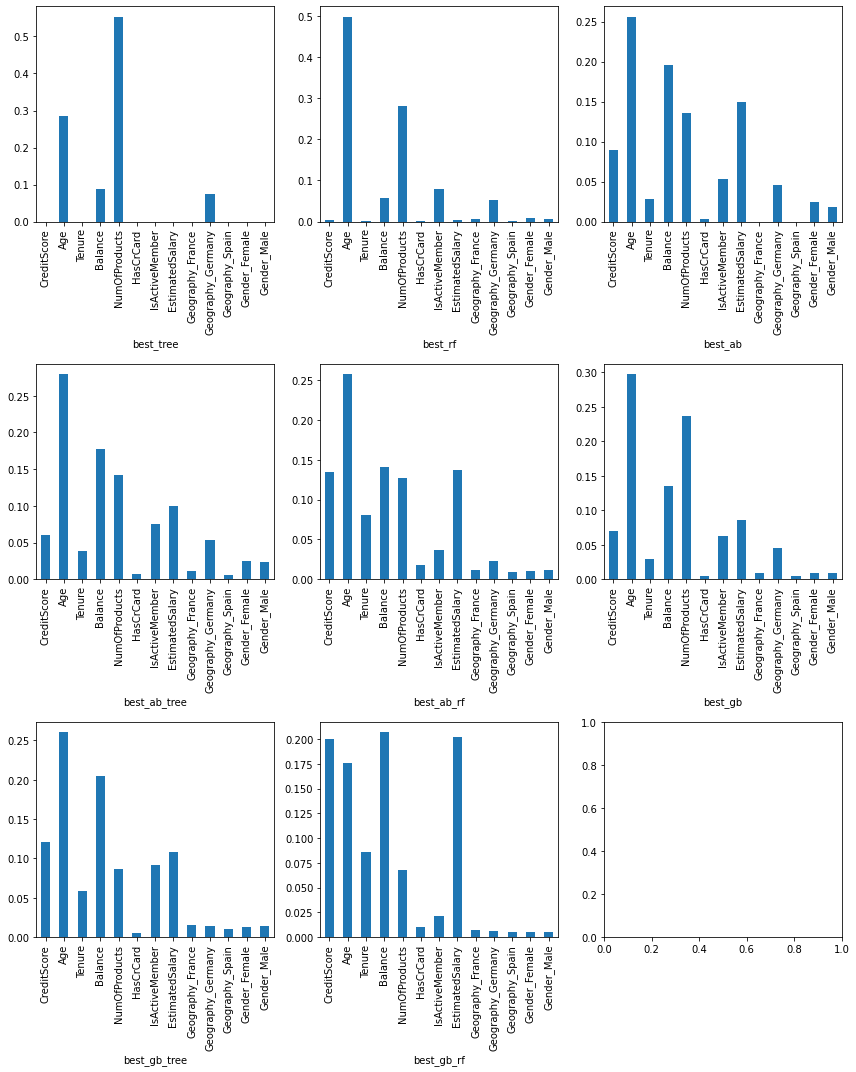

In [55]:
model_names = ['best_tree', 'best_rf', 'best_ab', 'best_ab_tree', 
               'best_ab_rf', 'best_gb', 'best_gb_tree', 'best_gb_rf']

def plot_feat_imp():
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 15))

    for idx, model in enumerate(models):
        ax = axes[int(idx / 3), idx % 3]
        model = model.fit(X_train, y_train)

        feat_importances=pd.Series(model.feature_importances_,
                                   index=features)

        feat_importances.plot.bar(ax=ax)
        #ax.set_title("Feature importances using MDI")
        ax.set_xlabel(model_names[idx])

    fig.tight_layout();

plot_feat_imp()

Although I have shown different types of model that is good at particular metrics, I remain unclear which model is the best. It is for you to choose one in terms of your interests. Thank you!